In [2]:
from vae import VAE, VAE_Loss
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm


mnist_dataset = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
test_dataset = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [3]:
#28x28 = 784
vae_model = VAE(latent_dim=64,dropout_prob=0.00)

res = vae_model(mnist_dataset[0][0].unsqueeze(0))
res[0].shape

torch.Size([1, 1, 28, 28])

In [ ]:
def monotonic_anneal(total_epochs, current_epoch, start_beta=0, end_beta=0.1):
    """linear interpolation between start_beta and end_beta base on current epoch"""
    beta = (start_beta * total_epochs  + end_beta * current_epoch)/ total_epochs 
    return beta 



Training: 100%|██████████| 200/200 [13:51<00:00,  4.16s/it, train_loss=0.3020, test_loss=0.3024, train_kl_loss=15.7088, test_kl_loss=15.5829, train_recon_loss=0.145716, test_recon_loss=0.147299, beta=0.009951] 


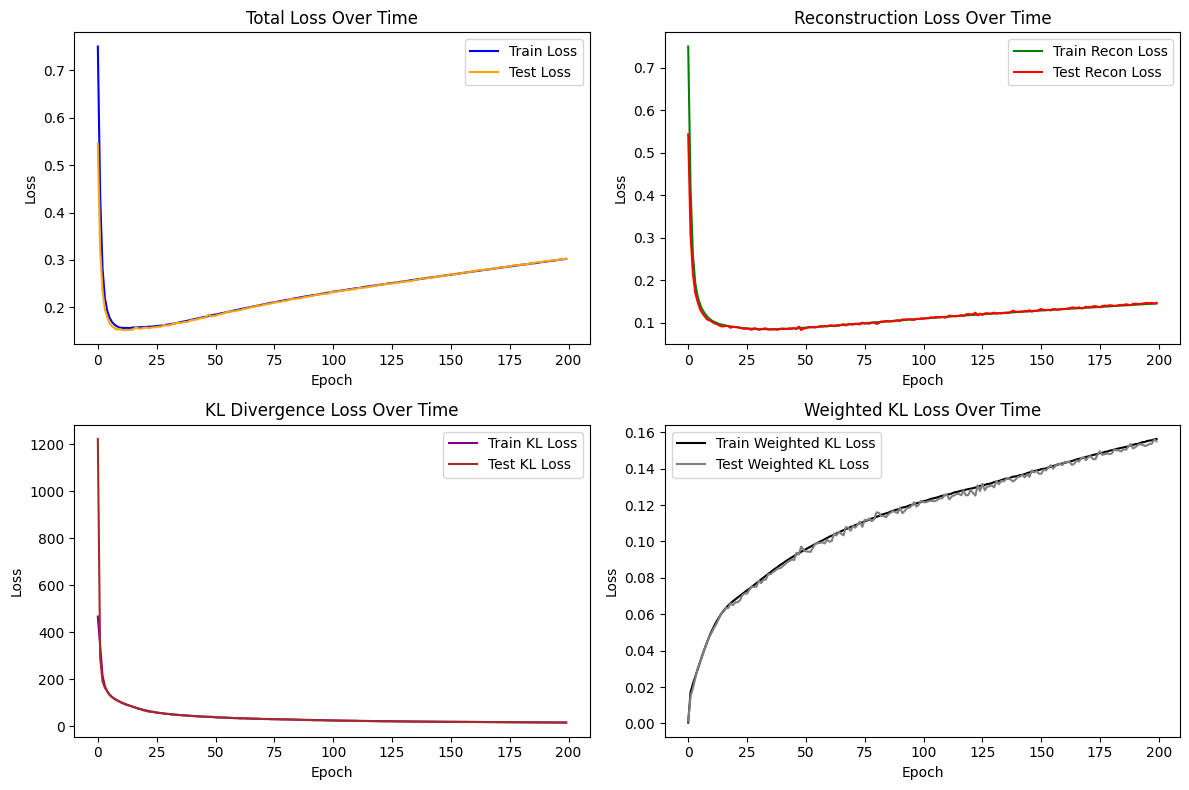

In [ ]:
start_beta = 0


loss = VAE_Loss(beta=start_beta)#
optimizer = torch.optim.Adam(vae_model.parameters(), lr=3e-4)


def train_epoch(model, train_loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    total_samples = 0
    total_recon_loss = 0
    total_kl_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss, reconstruction_loss, kl_loss = loss_fn((recon_batch, mu, logvar), data)
        batch_size = data.size(0)
        loss.backward()
        optimizer.step()
        total_recon_loss += reconstruction_loss.item() * batch_size
        total_kl_loss += kl_loss.item() * batch_size
        total_loss += loss.item() * batch_size
        total_samples += batch_size
        
    return total_loss / total_samples, total_recon_loss / total_samples, total_kl_loss /total_samples

def evaluate(model, test_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    total_samples = 0
    total_recon_loss = 0
    total_kl_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            batch_size = data.size(0)
            
            loss, reconstruction_loss, kl_loss = loss_fn((recon_batch, mu, logvar), data)
            total_loss += loss.item() * batch_size
            total_recon_loss += reconstruction_loss.item() * batch_size
            total_kl_loss += kl_loss.item() * batch_size
            total_samples += batch_size
            
    return total_loss / total_samples, total_recon_loss / total_samples, total_kl_loss /total_samples

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae_model = vae_model.to(device)

# Create data loaders
bs = 512
train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)

# Training loop
n_epochs = 200
train_losses, test_losses = [], []
train_kl_losses, test_kl_losses = [], []
train_recon_losses, test_recon_losses = [], []
train_weighted_kl_losses, test_weighted_kl_losses = [], []

progress_bar = tqdm(range(n_epochs), desc='Training')
for epoch in progress_bar:
    new_beta = monotonic_anneal(n_epochs, epoch, start_beta=1e-6, end_beta=1e-2)
    loss.beta = new_beta
    # Train and Evaluate
    train_loss, train_recon_loss, train_kl_loss = train_epoch(vae_model, train_loader, optimizer, loss, device)
    test_loss, test_recon_loss, test_kl_loss = evaluate(vae_model, test_loader, loss, device)

    # Store losses
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_recon_losses.append(train_recon_loss)
    test_recon_losses.append(test_recon_loss)
    train_kl_losses.append(train_kl_loss)
    test_kl_losses.append(test_kl_loss)
    train_weighted_kl_losses.append(train_kl_loss * new_beta)
    test_weighted_kl_losses.append(test_kl_loss * new_beta)

    progress_bar.set_postfix({
        'train_loss': f'{train_loss:.4f}',
        'test_loss': f'{test_loss:.4f}',
        'train_kl_loss': f'{train_kl_loss:.4f}',
        'test_kl_loss': f'{test_kl_loss:.4f}',
        'train_recon_loss': f'{train_recon_loss:4f}',
        'test_recon_loss': f'{test_recon_loss:4f}',
        'beta': f'{new_beta:.6f}'
    })

# Plot losses
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# 1. Total Loss
axes[0].plot(train_losses, label='Train Loss', color='blue')
axes[0].plot(test_losses, label='Test Loss', color='orange')
axes[0].set_title('Total Loss Over Time')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# 2. Reconstruction Loss
axes[1].plot(train_recon_losses, label='Train Recon Loss', color='green')
axes[1].plot(test_recon_losses, label='Test Recon Loss', color='red')
axes[1].set_title('Reconstruction Loss Over Time')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# 3. KL Divergence Loss
axes[2].plot(train_kl_losses, label='Train KL Loss', color='purple')
axes[2].plot(test_kl_losses, label='Test KL Loss', color='brown')
axes[2].set_title('KL Divergence Loss Over Time')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].legend()

# 4. Weighted KL Loss (KL * beta)
axes[3].plot(train_weighted_kl_losses, label='Train Weighted KL Loss', color='black')
axes[3].plot(test_weighted_kl_losses, label='Test Weighted KL Loss', color='gray')
axes[3].set_title('Weighted KL Loss Over Time')
axes[3].set_xlabel('Epoch')
axes[3].set_ylabel('Loss')
axes[3].legend()

plt.tight_layout()
plt.show()



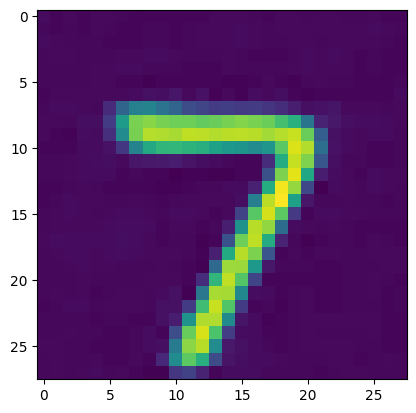

In [8]:
test_dataset[0][0].shape
vae_model.eval()
with torch.no_grad():
    decoded, _, _ = vae_model(test_dataset[0][0].to('cuda').unsqueeze(0))

plt.imshow(decoded[0].cpu().detach().numpy().reshape(28,28))


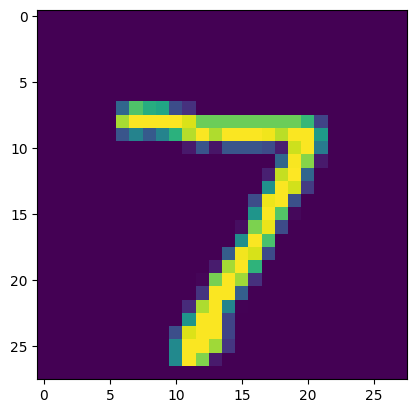

In [9]:
plt.imshow(test_dataset[0][0].numpy().reshape(28,28))


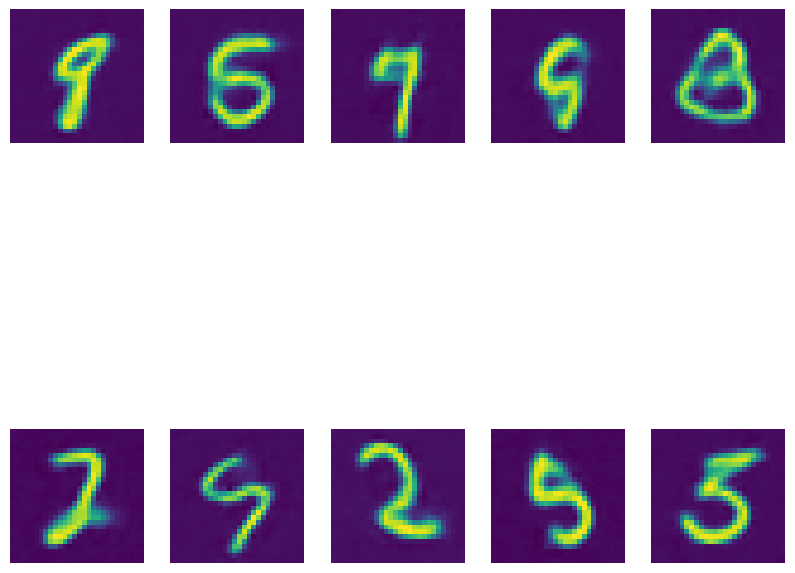

In [21]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(vae_model.generate(1)[0].cpu().detach().numpy().reshape(28,28))
    plt.axis('off')
plt.show()
